In [ ]:
import pandas as pd
import numpy as np
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


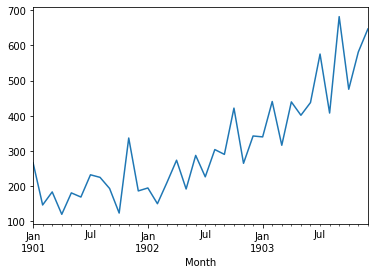

In [ ]:
series = pd.read_csv('https://raw.githubusercontent.com/shrutibalan4591/Practise/main/Time%20Series/ARIMA/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
plt.show()

The dataset has a clear trend. This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

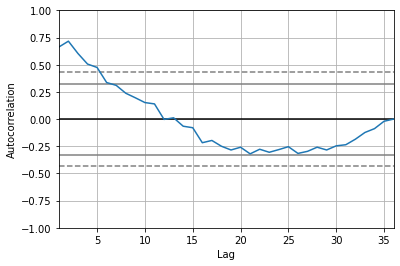

In [ ]:
# Check Autocorrelation
pd.plotting.autocorrelation_plot(series)
plt.show()

We can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the AR parameter of the model may be 5.



In [ ]:
!pip install statsmodels --upgrade

In [ ]:
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
series.index = series.index.to_period('M')

In [ ]:
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Wed, 26 Jan 2022   AIC                            408.969
Time:                        17:31:24   BIC                            418.301
Sample:                    01-31-1901   HQIC                           412.191
                         - 12-31-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

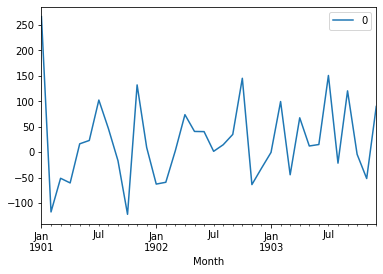

In [ ]:
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

We get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

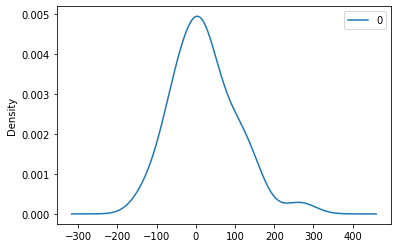

In [ ]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

We get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

In [ ]:
# summary stats of residuals
print(residuals.describe())

                0
count   36.000000
mean    21.936144
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147219
75%     68.848286
max    266.000000


The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [ ]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=343.272180, expected=342.300000
predicted=293.329674, expected=339.700000
predicted=368.668956, expected=440.400000
predicted=335.044741, expected=315.900000
predicted=363.220221, expected=439.300000
predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365674, expected=575.500000
predicted=459.415021, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231274, expected=475.300000
predicted=672.914943, expected=581.300000
predicted=531.541449, expected=646.900000


In [ ]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 89.021


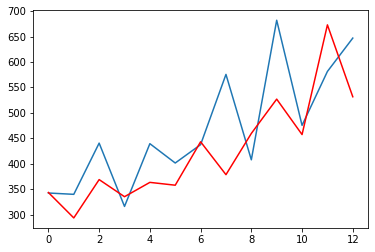

In [ ]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.



---
**Tuning Hyperparameters using gridsearch**


In [ ]:
# function to evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	return mse

In [ ]:
# Function to evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
import warnings
warnings.filterwarnings("ignore")

series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=52425.271
ARIMA(0, 0, 1) MSE=38257.790
ARIMA(0, 0, 2) MSE=23989.681
ARIMA(0, 1, 0) MSE=17730.518
ARIMA(0, 1, 1) MSE=10831.968
ARIMA(0, 1, 2) MSE=4670.968
ARIMA(0, 2, 0) MSE=65120.246
ARIMA(0, 2, 1) MSE=18001.166
ARIMA(0, 2, 2) MSE=5571.713
ARIMA(1, 0, 0) MSE=23112.494
ARIMA(1, 0, 1) MSE=12496.375
ARIMA(1, 0, 2) MSE=5941.953
ARIMA(1, 1, 0) MSE=7855.443
ARIMA(1, 1, 1) MSE=7733.869
ARIMA(1, 1, 2) MSE=8278.524
ARIMA(1, 2, 0) MSE=18110.757
ARIMA(1, 2, 1) MSE=7423.088
ARIMA(1, 2, 2) MSE=4291.637
ARIMA(2, 0, 0) MSE=10176.545
ARIMA(2, 0, 1) MSE=9791.747
ARIMA(2, 0, 2) MSE=9739.890
ARIMA(2, 1, 0) MSE=7235.798
ARIMA(2, 1, 1) MSE=7819.497
ARIMA(2, 1, 2) MSE=6971.647
ARIMA(2, 2, 0) MSE=9570.416
ARIMA(2, 2, 1) MSE=5905.357
ARIMA(2, 2, 2) MSE=6530.003
ARIMA(4, 0, 0) MSE=10195.920
ARIMA(4, 0, 1) MSE=10294.871
ARIMA(4, 0, 2) MSE=9506.044
ARIMA(4, 1, 0) MSE=9037.908
ARIMA(4, 1, 1) MSE=7194.176
ARIMA(4, 1, 2) MSE=7090.449
ARIMA(4, 2, 0) MSE=7292.660
ARIMA(4, 2, 1) MSE=5508.510
ARIMA(4

In [ ]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [ ]:
for t in range(len(test)):
	model = ARIMA(history, order=(1, 2, 2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=367.715269, expected=342.300000
predicted=351.202896, expected=339.700000
predicted=366.494570, expected=440.400000
predicted=387.906124, expected=315.900000
predicted=424.128274, expected=439.300000
predicted=408.744985, expected=401.300000
predicted=441.090124, expected=437.400000
predicted=448.636861, expected=575.500000
predicted=475.237491, expected=407.600000
predicted=539.858682, expected=682.000000
predicted=486.644279, expected=475.300000
predicted=611.718325, expected=581.300000
predicted=600.639919, expected=646.900000


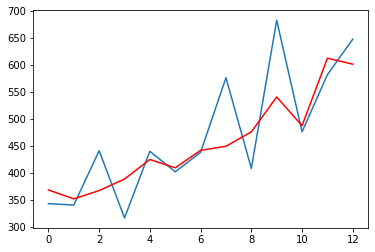

In [ ]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()